# vLLM: High-Performance Inference Engine for LLMs

In this notebook, we'll explore vLLM, an advanced inference engine designed to maximize the performance of Large Language Models (LLMs) on GPU hardware. vLLM addresses key performance bottlenecks in traditional inference systems, achieving substantially higher throughput while maintaining low latency.

## 1. Introduction to Inference Engines

### Why LLM Inference is Challenging

Deploying LLMs efficiently presents several challenges:

1. **Memory Constraints**: LLMs have billions of parameters that must be loaded into GPU memory
2. **Attention Computation**: Quadratic scaling with sequence length makes attention expensive
3. **Sequential Generation**: Auto-regressive generation is inherently sequential
4. **Dynamic Batch Sizes**: Variable-length inputs and outputs make static batching inefficient
5. **GPU Utilization**: Traditional inference pipelines often leave GPUs underutilized

Specialized inference engines like vLLM are designed to address these challenges through innovative techniques and optimizations.

### Installation Requirements

Before we begin, here are the requirements for installing vLLM:

vLLM requires:
- NVIDIA GPU with compute capability 7.0+ (V100, T4, A100, H100, etc.)
- CUDA 11.8+ (best with CUDA 12.1)
- NVIDIA drivers (tested with Driver 535+)
- PyTorch 2.5.1 (recommended)

### Core Value Propositions of vLLM

vLLM offers several key advantages for LLM inference:

1. **PagedAttention**: Efficient KV cache management that eliminates waste and reduces memory fragmentation
2. **Continuous Batching**: Dynamic handling of requests to maximize GPU utilization 
3. **Optimized CUDA Kernels**: Highly optimized implementations of computational bottlenecks
4. **Tensor Parallelism**: Ability to split model across multiple GPUs
5. **Quantization Support**: Precision reduction (INT8, INT4) with minimal accuracy loss

These innovations allow vLLM to achieve 2-18x higher throughput than other inference engines while maintaining low latency.

## 2. PagedAttention: Memory-Efficient KV Caching

### The KV Cache Problem

During LLM inference, the key-value (KV) pairs from previous tokens must be stored to avoid recomputation. Traditional approaches allocate a fixed-size cache for each request based on the maximum possible sequence length, leading to significant memory waste when:

1. Actual sequences are shorter than the maximum length
2. Each sequence in a batch has different lengths

This problem becomes more severe with multiple simultaneous requests and longer context windows.

### How PagedAttention Works

PagedAttention applies virtual memory concepts to KV cache management:

1. **Blocks Instead of Sequences**: PagedAttention divides the KV cache into fixed-size memory blocks (e.g., 16 tokens per block)
2. **Physical and Logical Separation**: Maintains logical sequences using a block table that maps sequence positions to physical memory blocks
3. **On-Demand Allocation**: Only allocates blocks when needed, rather than preallocating for maximum length
4. **Memory Reuse**: Freed blocks from completed sequences can be immediately reused for new requests

Let's see a basic example of how this works:

In [1]:
!uv pip install bitsandbytes>=0.45.3
!uv pip install packaging ninja
!uv pip install flash-attn --no-build-isolation
!uv pip install torch torchvision torchaudio
!uv pip install ipywidgets

Audited 1 package in 69ms


Audited 2 packages in 55ms
Resolved 26 packages in 312ms                                        
Prepared 1 package in 13.26s                                             
Installed 1 package in 318mst1                              
Bytecode compiled 18369 files in 2.10s
 + flash-attn==2.7.4.post1


In [11]:
import torch
print(torch.__version__)
# Check torch and CUDA versions, and select the correct flashinfer version based on:
# https://docs.flashinfer.ai/installation.html

2.6.0+cu124


In [12]:
!uv pip install flashinfer-python -i https://flashinfer.ai/whl/cu124/torch2.6/


⠙ Resolving dependencies...                                                     

Resolved 25 packages in 4.40s                                        
Prepared 1 package in 4.50s                                              
Installed 1 package in 970ms2.5+cu124torch2.6               
Bytecode compiled 18504 files in 870ms
 + flashinfer-python==0.2.5+cu124torch2.6


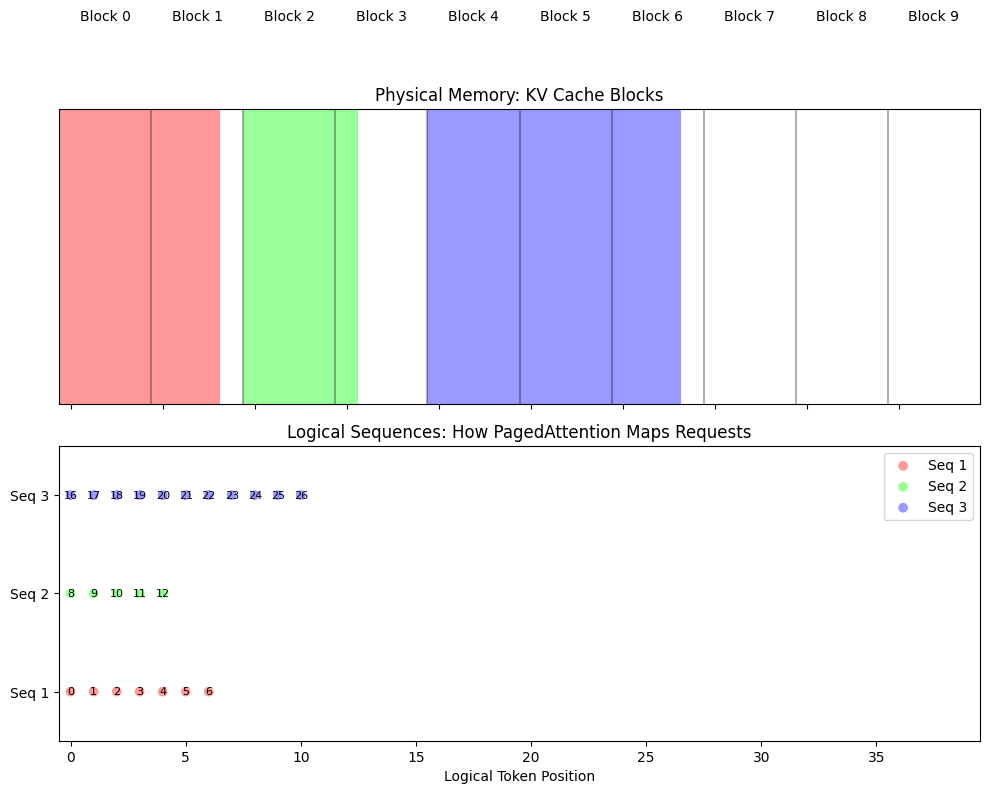

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Visualization helper for PagedAttention concept
def visualize_paged_attention(block_size=4, num_blocks=10, sequences=None):
    if sequences is None:
        sequences = [
            {'name': 'Seq 1', 'length': 7, 'start_block': 0},
            {'name': 'Seq 2', 'length': 5, 'start_block': 2},
            {'name': 'Seq 3', 'length': 11, 'start_block': 4},
        ]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Physical memory blocks
    blocks = np.zeros(num_blocks * block_size)
    colors = ['#ff9999', '#99ff99', '#9999ff']
    
    # Fill blocks based on sequences
    for i, seq in enumerate(sequences):
        start_idx = seq['start_block'] * block_size
        for j in range(min(seq['length'], (num_blocks - seq['start_block']) * block_size)):
            blocks[start_idx + j] = i + 1
    
    # Display physical memory
    ax1.set_title('Physical Memory: KV Cache Blocks')
    for i in range(num_blocks):
        ax1.axvline(x=i*block_size - 0.5, color='black', linestyle='-', alpha=0.3)
        ax1.text(i*block_size + block_size/2 - 0.5, -0.8, f'Block {i}', ha='center')
    
    cmap = plt.cm.colors.ListedColormap(['white'] + colors)
    ax1.imshow(blocks.reshape(1, -1), aspect='auto', cmap=cmap, vmin=0, vmax=len(sequences))
    ax1.set_yticks([])
    ax1.set_xticks(np.arange(0, num_blocks*block_size, block_size))
    ax1.set_xticklabels([])
    
    # Display logical sequences
    ax2.set_title('Logical Sequences: How PagedAttention Maps Requests')
    for i, seq in enumerate(sequences):
        logical_seq = np.zeros(num_blocks * block_size)
        for j in range(seq['length']):
            block_idx = seq['start_block'] + j // block_size
            if block_idx < num_blocks:
                token_idx = (block_idx * block_size) + (j % block_size)
                logical_seq[j] = token_idx + 1  # Where this token is stored in physical memory
                
        ax2.scatter(range(seq['length']), [i]*seq['length'], 
                   c=[colors[i]]*seq['length'], label=seq['name'])
        for j in range(seq['length']):
            if logical_seq[j] > 0:
                ax2.text(j, i, f'{int(logical_seq[j]-1)}', ha='center', va='center', fontsize=8)
    
    ax2.set_xlim(-0.5, num_blocks*block_size - 0.5)
    ax2.set_ylim(-0.5, len(sequences) - 0.5)
    ax2.set_yticks(range(len(sequences)))
    ax2.set_yticklabels([s['name'] for s in sequences])
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Logical Token Position')
    
    plt.tight_layout()
    
visualize_paged_attention()

### Benefits of PagedAttention

PagedAttention provides several key advantages:

1. **Memory Efficiency**: Uses up to 65% less memory than traditional KV caching
2. **Elimination of Memory Fragmentation**: Blocks can be allocated and released dynamically
3. **Support for Variable-Length Sequences**: Efficiently handles sequences of any length
4. **Higher Throughput**: More requests can be processed simultaneously with the same memory

The CUDA implementation of PagedAttention in vLLM includes highly optimized attention kernels that maintain computational efficiency while providing these memory benefits.

## 3. Continuous Batching for Maximum GPU Utilization

### Static vs. Continuous Batching

Traditional inference systems use static batching, where:
1. A fixed number of requests are grouped into a batch
2. The entire batch is processed together
3. No new requests can join until the batch completes
4. All sequences in the batch must wait for the longest sequence to finish

This approach leads to poor GPU utilization because:
- GPUs are idle while waiting for new batches
- Shorter sequences waste compute waiting for longer ones
- Batch size must be small to maintain reasonable latency

Continuous batching solves these problems by dynamically adding and removing sequences from the batch.

### How Continuous Batching Works

vLLM implements continuous batching through a scheduling algorithm that:

1. **Dynamically Adds Requests**: New requests join the batch as soon as they arrive
2. **Independently Manages Sequences**: Each sequence progresses at its own pace
3. **Immediately Removes Completed Sequences**: Frees resources as soon as generation completes
4. **Prioritizes Requests**: Can implement strategies like FIFO, round-robin, or priority queuing

Let's look at a comparison between static and continuous batching:

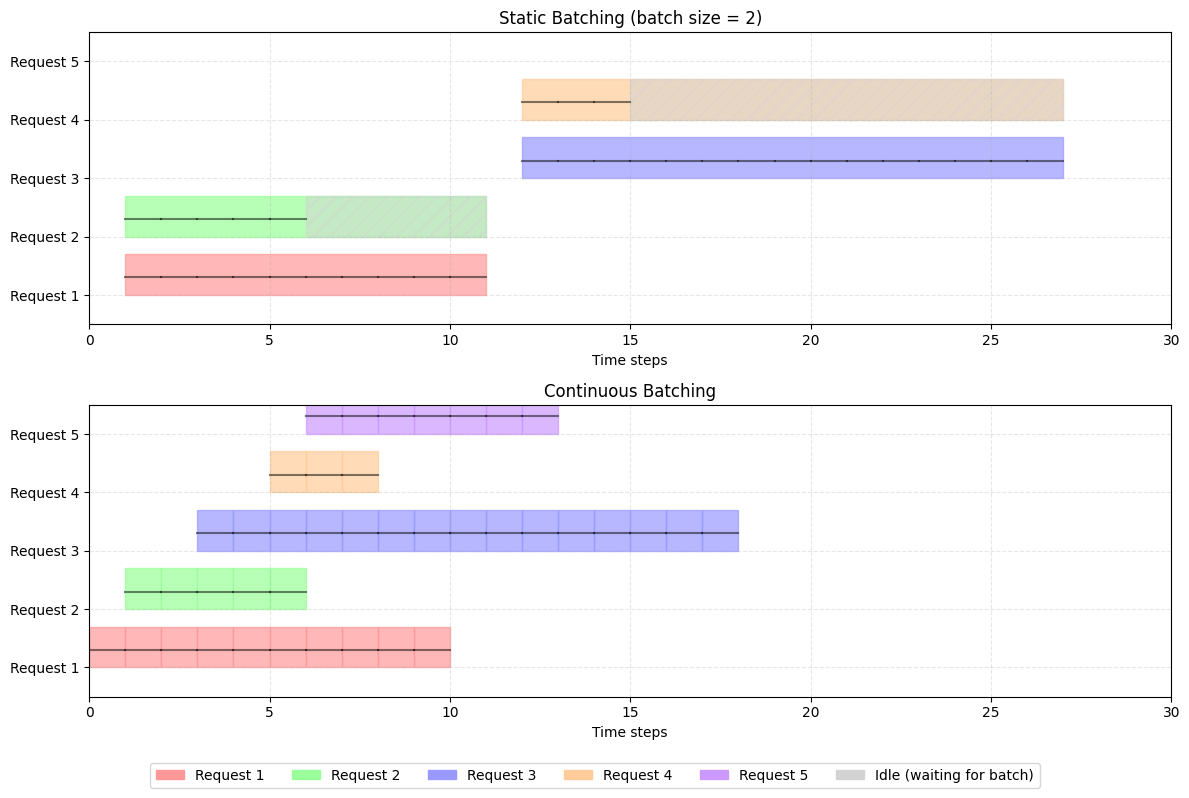

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Visualizing static vs continuous batching
def compare_batching_methods():
    # Setup
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Define request data: [arrival_time, tokens_to_generate]
    requests = [
        [0, 10],   # Request 1: arrives at t=0, needs 10 tokens
        [1, 5],    # Request 2: arrives at t=1, needs 5 tokens
        [3, 15],   # Request 3: arrives at t=3, needs 15 tokens
        [5, 3],    # Request 4: arrives at t=5, needs 3 tokens
        [6, 7],    # Request 5: arrives at t=6, needs 7 tokens
    ]
    
    # Colors for each request
    colors = ['#ff9999', '#99ff99', '#9999ff', '#ffcc99', '#cc99ff']
    
    # Static batching (batch size = 2)
    ax1.set_title('Static Batching (batch size = 2)')
    batch_size = 2
    current_time = 0
    batch_queue = []
    processing_batch = False
    batch_end_time = 0
    
    for t in range(30):  # Simulate 30 time steps
        # Add new arrivals to queue
        for i, req in enumerate(requests):
            if req[0] == t:
                batch_queue.append((i, req[1]))
        
        # Start new batch if we're not processing and have enough requests
        if not processing_batch and len(batch_queue) >= batch_size:
            processing_batch = True
            current_batch = batch_queue[:batch_size]
            batch_queue = batch_queue[batch_size:]
            
            # Determine longest sequence in batch
            max_tokens = max([r[1] for r in current_batch])
            batch_end_time = t + max_tokens
            
            # Draw rectangles for each request in this batch
            for idx, (req_idx, tokens) in enumerate(current_batch):
                rect = Rectangle((t, req_idx), max_tokens, 0.7, color=colors[req_idx], alpha=0.7)
                ax1.add_patch(rect)
                
                # Add diagonal lines for actual token generation
                for token in range(tokens):
                    ax1.plot([t+token, t+token+1], [req_idx+0.3, req_idx+0.3], color='black', alpha=0.5)
                
                # Add idle time (waiting for longest sequence)
                if tokens < max_tokens:
                    rect = Rectangle((t+tokens, req_idx), max_tokens-tokens, 0.7, 
                                    color='lightgray', alpha=0.5, hatch='//')
                    ax1.add_patch(rect)
        
        # Check if current batch is done
        if processing_batch and t == batch_end_time:
            processing_batch = False
    
    # Continuous batching
    ax2.set_title('Continuous Batching')
    active_requests = {}
    
    for t in range(30):  # Simulate 30 time steps
        # Add new arrivals to active requests
        for i, req in enumerate(requests):
            if req[0] == t:
                active_requests[i] = {'start': t, 'tokens_left': req[1]}
        
        # Process all active requests
        finished = []
        for req_idx, req_data in active_requests.items():
            if req_data['tokens_left'] > 0:
                # Draw token generation step
                token_num = req_data['start'] + req[1] - req_data['tokens_left']
                ax2.plot([t, t+1], [req_idx+0.3, req_idx+0.3], color='black', alpha=0.5)
                
                # Draw rectangle for this time step
                rect = Rectangle((t, req_idx), 1, 0.7, color=colors[req_idx], alpha=0.7)
                ax2.add_patch(rect)
                
                # Decrement tokens left
                req_data['tokens_left'] -= 1
                
                # Check if request is finished
                if req_data['tokens_left'] == 0:
                    finished.append(req_idx)
        
        # Remove finished requests
        for req_idx in finished:
            del active_requests[req_idx]
    
    # Formatting
    for ax in [ax1, ax2]:
        ax.set_xlim(0, 30)
        ax.set_ylim(-0.5, len(requests) - 0.5)
        ax.set_yticks(range(len(requests)))
        ax.set_yticklabels([f'Request {i+1}' for i in range(len(requests))])
        ax.set_xlabel('Time steps')
        ax.grid(True, linestyle='--', alpha=0.3)
    
    # Add legend
    handles = [Rectangle((0,0), 1, 1, color=colors[i]) for i in range(len(requests))]
    handles.append(Rectangle((0,0), 1, 1, color='lightgray', hatch='//'))
    labels = [f'Request {i+1}' for i in range(len(requests))]
    labels.append('Idle (waiting for batch)')
    
    plt.figlegend(handles, labels, loc='lower center', ncol=len(handles), bbox_to_anchor=(0.5, 0))
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    
compare_batching_methods()

### Benefits of Continuous Batching

Continuous batching provides several critical advantages:

1. **Higher GPU Utilization**: Keeps the GPU busy by continuously adding new requests
2. **Lower Latency**: No waiting for batch formation or for longer sequences to complete
3. **Higher Throughput**: Processes more tokens per second by eliminating idle time
4. **Better QoS**: Can implement prioritization for critical requests

When combined with PagedAttention, continuous batching allows vLLM to achieve much higher throughput than traditional inference engines, especially under high load.

## 4. Flash Attention for Compute Optimization

While PagedAttention optimizes memory usage and continuous batching improves scheduling, the actual attention computation remains a bottleneck. Flash Attention is an algorithm that optimizes attention computation by reducing memory I/O between GPU high-bandwidth memory (HBM) and on-chip SRAM.

### How Flash Attention Works

Standard attention implementation has three key inefficiencies:

1. **Multiple HBM Accesses**: Reading Q, K, V matrices multiple times
2. **Storing Large Attention Matrices**: O(N²) memory for sequence length N
3. **Softmax Stability Tricks**: Extra passes to compute max values

Flash Attention addresses these issues by:

1. **Tiled Computation**: Breaking large matrices into smaller blocks that fit in SRAM
2. **Online Softmax Algorithm**: Computing softmax incrementally without storing the full attention matrix
3. **Fused Operations**: Combining multiple operations to reduce memory I/O

The algorithm time complexity remains O(N²) but with drastically reduced memory I/O.

### vLLM Integration with Flash Attention

vLLM integrates FlashAttention (via FlashInfer) as its attention backend to further optimize inference performance:

1. **Reduced Memory Bandwidth**: Lower memory I/O means faster attention computation
2. **Lower GPU Memory Usage**: No need to materialize the full attention matrix
3. **Faster Backward Pass**: More efficient gradient computation (when using vLLM for fine-tuning)
4. **Optimized for Modern GPUs**: Tailored for NVIDIA architectures (Ampere, Hopper, etc.)

The combination of PagedAttention memory efficiency and FlashAttention compute efficiency gives vLLM exceptional performance.

## 5. Implementing Efficient Batch Inference with vLLM

Now let's see how to use vLLM in practice. We'll first look at a simple example of how to load a model and generate completions.

In [4]:
# !pip install vllm
# Basic vLLM usage example

from vllm import LLM, SamplingParams

# Initialize the model
# This loads the model onto the GPU(s)
llm = LLM(model="mistralai/Mistral-7B-Instruct-v0.2")

# Set sampling parameters
sampling_params = SamplingParams(
    temperature=0.7,
    top_p=0.95,
    max_tokens=256
)

# Single prompt generation
prompts = ["Write a short story about a robot learning to paint:"]
outputs = llm.generate(prompts, sampling_params)

# Print the generated text
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print(f"Prompt: {prompt}")
    print(f"Generated text: {generated_text}")
    print("---")

/mnt/weka/aisg/ob1/learning_llm_handbook/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 05-15 11:24:16 [__init__.py:239] Automatically detected platform cuda.


2025-05-15 11:24:18,038	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 05-15 11:24:25 [config.py:717] This model supports multiple tasks: {'score', 'generate', 'reward', 'classify', 'embed'}. Defaulting to 'generate'.
INFO 05-15 11:24:25 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=16384.


/mnt/weka/aisg/ob1/learning_llm_handbook/.venv/lib/python3.12/site-packages/vllm/transformers_utils/tokenizer_group.py:23: FutureWarning: It is strongly recommended to run mistral models with `--tokenizer-mode "mistral"` to ensure correct encoding and decoding.
  self.tokenizer = get_tokenizer(self.tokenizer_id, **tokenizer_config)


INFO 05-15 11:24:27 [core.py:58] Initializing a V1 LLM engine (v0.8.5.post1) with config: model='mistralai/Mistral-7B-Instruct-v0.2', speculative_config=None, tokenizer='mistralai/Mistral-7B-Instruct-v0.2', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=None, served_model_name=mistralai/Mistral-7B-Instruct-v0.2, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_caching=Tru

Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  33% Completed | 1/3 [00:00<00:01,  1.93it/s]
Loading safetensors checkpoint shards:  67% Completed | 2/3 [00:01<00:00,  1.51it/s]
Loading safetensors checkpoint shards: 100% Completed | 3/3 [00:02<00:00,  1.40it/s]
Loading safetensors checkpoint shards: 100% Completed | 3/3 [00:02<00:00,  1.46it/s]



INFO 05-15 11:24:35 [loader.py:458] Loading weights took 2.28 seconds
INFO 05-15 11:24:35 [gpu_model_runner.py:1347] Model loading took 13.4967 GiB and 3.435789 seconds
INFO 05-15 11:24:40 [backends.py:420] Using cache directory: /mnt/weka/home/brandon/.cache/vllm/torch_compile_cache/c018521bf9/rank_0_0 for vLLM's torch.compile
INFO 05-15 11:24:40 [backends.py:430] Dynamo bytecode transform time: 5.43 s
INFO 05-15 11:24:44 [backends.py:118] Directly load the compiled graph(s) for shape None from the cache, took 3.163 s
INFO 05-15 11:24:45 [monitor.py:33] torch.compile takes 5.43 s in total
INFO 05-15 11:24:45 [kv_cache_utils.py:634] GPU KV cache size: 897,824 tokens
INFO 05-15 11:24:45 [kv_cache_utils.py:637] Maximum concurrency for 32,768 tokens per request: 27.40x
INFO 05-15 11:25:00 [gpu_model_runner.py:1686] Graph capturing finished in 15 secs, took 0.64 GiB
INFO 05-15 11:25:00 [core.py:159] init engine (profile, create kv cache, warmup model) took 25.51 seconds
INFO 05-15 11:25:00

Processed prompts: 100%|██████████████████████████| 1/1 [00:01<00:00,  1.53s/it, est. speed input: 7.82 toks/s, output: 166.91 toks/s]

Prompt: Write a short story about a robot learning to paint:
Generated text: 

Title: The Artistic Machine

In the heart of the bustling city of Metropolis, nestled among the towering skyscrapers and sprawling factories, was an unassuming art studio. This was the sanctum of renowned painter, Victor Bellamy. For years, Bellamy had captivated the world with his breathtaking masterpieces, each one a testament to the limitless depths of human creativity.

However, as Bellamy grew older, his health began to decline. He knew that he couldn't continue creating art indefinitely, and so he made a decision that would change the course of art history forever. He would create a robot, programmed to learn and eventually surpass his own artistic abilities.

Bellamy named his creation ADA, an acronym for Artistic Development and Analysis. ADA was a marvel of engineering, designed with the latest advancements in robotics, artificial intelligence, and nanotechnology. Bellamy spent countless hours progr

### Batch Processing with Thread Concurrency

In practice, you can simply send all of your requests at once to the vLLM server and the scheduler in vLLM will handle the process of batching the largest number of requests together based on the kv cache available.

The one exception to this is sending tens of thousands of requests at once may overload the server and cause it to crash. In this case, you can then explore other concurrency features to send requests in smaller batches.

### Deploying a vLLM Server

For production deployment, vLLM offers a server mode with a REST API compatible with the OpenAI API. This makes it easy to integrate into existing applications.

# Run this in a terminal with access to the GPU to start the vLLM server
```bash
!uv run python -m vllm.entrypoints.openai.api_server \
    --model unsloth/tinyllama-bnb-4bit \
    --host 0.0.0.0 \
    --port 8000
```

Then you can query the server using standard HTTP requests that mimic the OpenAI API format:

In [1]:
import requests
import json

# Example of calling a vLLM server with OpenAI-compatible API
def query_vllm_server(prompt, max_tokens=100):
    url = "http://localhost:8000/v1/completions"
    
    payload = {
        "model": "unsloth/tinyllama-bnb-4bit",
        "prompt": prompt,
        "max_tokens": max_tokens,
        "temperature": 0.7,
        "stream": False
    }
    
    headers = {
        "Content-Type": "application/json"
    }
    
    try:
        response = requests.post(url, headers=headers, data=json.dumps(payload))
        return response.json()
    except Exception as e:
        return {"error": str(e)}

# Example usage (if server is running)
result = query_vllm_server("Write a haiku about artificial intelligence:")
print(json.dumps(result, indent=2))

{
  "id": "cmpl-951af434a6124b01b0b5f6758b5ed557",
  "object": "text_completion",
  "created": 1747372222,
  "model": "unsloth/tinyllama-bnb-4bit",
  "choices": [
    {
      "index": 0,
      "text": " ar dr.\ncertified financial planner\n\u00a9 2017 DearMoney.com\nMoney Life\nProfessional Advisory\nDearMoney\u00ae is a registered trademark of Dear Money, LLC.\nDearMoney\u2122 is a service mark of Dear Money, LLC.",
      "logprobs": null,
      "finish_reason": "stop",
      "stop_reason": null,
      "prompt_logprobs": null
    }
  ],
  "usage": {
    "prompt_tokens": 9,
    "total_tokens": 83,
    "completion_tokens": 74,
    "prompt_tokens_details": null
  }
}


## 6. Advanced vLLM Configurations

vLLM supports several advanced configurations to further optimize performance:

### Tensor Parallelism

For large models that don't fit on a single GPU, vLLM supports tensor parallelism to split the model across multiple GPUs.

In the logs below, you will notice something called "NCCL" which is the NVIDIA Collective Communications Library that handles the communication between the GPUs to allow for multi-gpu and multi-node (distributed) operation of GPUs.

You will also notice that the model is loaded on two GPUs, and you can tell by the rank {n} indicating the GPU number in the logs.

In practice, you will experiment with the various hyperparameters (enabling/disabling tensor parallelism, batch size, KV cache size, etc.) to find the best configuration for your use case.

In [10]:
# Example of using tensor parallelism across multiple GPUs
from vllm import LLM, SamplingParams

# Load a larger model with tensor parallelism across GPUs
llm = LLM(
    model="Qwen/Qwen2.5-32B-Instruct",
    tensor_parallel_size=2,  # Use 2 GPUs or more
    gpu_memory_utilization=0.85,  # Control memory usage
)

# Set sampling parameters
sampling_params = SamplingParams(
    temperature=0.7,
    top_p=0.95,
    max_tokens=256
)

output = llm.generate(["Write a haiku about programming"], sampling_params)
print(output)

INFO 05-16 05:44:06 [__init__.py:239] Automatically detected platform cuda.
INFO 05-16 05:44:14 [config.py:717] This model supports multiple tasks: {'classify', 'score', 'reward', 'generate', 'embed'}. Defaulting to 'generate'.
INFO 05-16 05:44:15 [config.py:1770] Defaulting to use mp for distributed inference
INFO 05-16 05:44:15 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=16384.
INFO 05-16 05:44:16 [core.py:58] Initializing a V1 LLM engine (v0.8.5.post1) with config: model='Qwen/Qwen2.5-32B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-32B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=2, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, deco

Loading safetensors checkpoint shards:   0% Completed | 0/17 [00:00<?, ?it/s]


(VllmWorker rank=0 pid=97401) INFO 05-16 05:44:28 [loader.py:458] Loading weights took 7.72 seconds
(VllmWorker rank=0 pid=97401) INFO 05-16 05:44:28 [gpu_model_runner.py:1347] Model loading took 30.7099 GiB and 8.837192 seconds
(VllmWorker rank=1 pid=97402) INFO 05-16 05:44:28 [loader.py:458] Loading weights took 7.68 seconds
(VllmWorker rank=1 pid=97402) INFO 05-16 05:44:28 [gpu_model_runner.py:1347] Model loading took 30.7099 GiB and 9.275794 seconds
(VllmWorker rank=0 pid=97401) (VllmWorker rank=1 pid=97402) INFO 05-16 05:44:39 [backends.py:420] Using cache directory: /mnt/weka/home/brandon/.cache/vllm/torch_compile_cache/b7e2e327bb/rank_0_0 for vLLM's torch.compile
INFO 05-16 05:44:39 [backends.py:420] Using cache directory: /mnt/weka/home/brandon/.cache/vllm/torch_compile_cache/b7e2e327bb/rank_1_0 for vLLM's torch.compile
(VllmWorker rank=1 pid=97402) INFO 05-16 05:44:39 [backends.py:430] Dynamo bytecode transform time: 10.40 s
(VllmWorker rank=0 pid=97401) INFO 05-16 05:44:39 [b

Processed prompts:   0%|                                       | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 t…

[RequestOutput(request_id=0, prompt='Write a haiku about programming', prompt_token_ids=[7985, 264, 6386, 38242, 911, 15473], encoder_prompt=None, encoder_prompt_token_ids=None, prompt_logprobs=None, outputs=[CompletionOutput(index=0, text=' in the style of Matsuo Basho. Code flows like river,\nBugs hide in leafy branches—\nSilence speaks in truth.', token_ids=[304, 279, 1707, 315, 67179, 23137, 38530, 78, 13, 6119, 27455, 1075, 14796, 345, 33, 13299, 10265, 304, 15933, 88, 23091, 2293, 198, 27571, 763, 21191, 304, 8046, 13, 151643], cumulative_logprob=None, logprobs=None, finish_reason=stop, stop_reason=151643)], finished=True, metrics=None, lora_request=None, num_cached_tokens=None, multi_modal_placeholders={})]


In [13]:
prompt = output[0].prompt
generated_text = output[0].outputs[0].text
print(f"Prompt: {prompt}")
print(f"Generated text: {generated_text}")
print("---")

Prompt: Write a haiku about programming
Generated text:  in the style of Matsuo Basho. Code flows like river,
Bugs hide in leafy branches—
Silence speaks in truth.
---


## Introducing Llama.cpp and GGUF (continued next week)

Llama.cpp is a highly optimized C++ library designed to run large language models (LLMs) like Llama (and others) on local hardware with minimal dependencies. 

Its primary goal is to enable efficient inference of LLMs on consumer-grade hardware, including CPUs and GPUs, without requiring massive computational resources or complex setups.

Because it compiles down to a minimal binary, it makes local or on-device deployment straightforward.

It supports multiple quantization schemes, letting users reduce model size so the model can fit into CPU memory or smaller GPUs.

GGUF is a file format for storing model weights and metadata in a way that can be easily loaded by Llama.cpp (and tools that adopt the same standard).

Supports quantized weights (like Q4, Q5, Q8, etc.) and other details needed by Llama.cpp.

Reduction of friction: The goal is to have a single consistent approach so that conversions and updates are simpler for the user.

### vLLM vs Llama.cpp

| Feature | vLLM | Llama.cpp |
|---------|------|-----------|
| Framework Type | Python-based serving framework | C++-based local inference |
| Target Hardware | GPUs for large-scale inference | Commodity hardware (laptops, CPUs, small GPUs) |
| Key Features | - Dynamic batching<br>- Multi-GPU support<br>- High throughput | - Small footprint<br>- Local deployment<br>- Minimal dependencies |
| Best Use Case | Production environment with:<br>- Heavy GPU usage<br>- Dynamic batching<br>- Multiple concurrent requests | Local inference with:<br>- CPU or modest GPU<br>- Embedded C++ environment<br>- Resource-constrained devices |
| Scale | Large-scale server solution | Local/small-scale solution |

In short, Llama.cpp and GGUF are geared towards local inference scenarios, whereas frameworks like vLLM are oriented towards high-performance server-based inference with heavier GPU investment and more robust serving features.

**Note**: Llama.cpp doesn’t require Python, PyTorch, or TensorFlow to run locally. However, for educational purposes, we will use Python in this example to highlight the strenghts of using Llama.cpp. 

You could use the Llama.cpp CLI to run the model just like how you would with Ollama. 

In [ ]:
# !uv pip install llama-cpp-python

In [3]:
# !uv pip install -U "huggingface_hub[cli]"
# !uv pip install hf_transfer

Resolved 16 packages in 36ms                                         
Bytecode compiled 20435 files in 1.12s
Resolved 1 package in 20ms                                           
Prepared 1 package in 38ms                                               
Installed 1 package in 15ms                                 
Bytecode compiled 20436 files in 1.19s
 + hf-transfer==0.1.9


In [6]:
!HF_HUB_ENABLE_HF_TRANSFER=1 huggingface-cli download google/gemma-3-27b-it-qat-q4_0-gguf --include "gemma-3-27b-it-q4_0.gguf" --local-dir ./models/

gemma-3-27b-it-q4_0.gguf: 100%|████████████▉| 17.2G/17.2G [00:18<00:00, 917MB/s]
Download complete. Moving file to models/gemma-3-27b-it-q4_0.gguf
/mnt/weka/aisg/ob1/learning_llm_handbook/models


In [7]:
from llama_cpp import Llama
import os

# Set path to the model file - update this to your model's location
model_path = "./models/gemma-3-27b-it-q4_0.gguf"

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}. Please download it first.")

llm = Llama(
    model_path=model_path,
    n_ctx=4096,      # Context window size
    n_threads=8,     # Number of CPU threads to use
    n_batch=512,     # Batch size for prompt processing
    verbose=False    # Set to True for more detailed logs
)

print(f"Model loaded successfully: {model_path}")

llama_context: n_ctx_per_seq (4096) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


Model loaded successfully: ./models/gemma-3-27b-it-q4_0.gguf


In [9]:
prompt = "Write a story about a robot learning to paint"

output = llm(
    prompt,
    max_tokens=512,      # Maximum number of tokens to generate
    temperature=0.7,     # Controls randomness (lower = more deterministic)
    top_p=0.95,          # Top-p sampling
    top_k=50,            # Top-k sampling
    repeat_penalty=1.1   # Penalty for repeating tokens
)

print(prompt + output["choices"][0]["text"])

Write a story about a robot learning to paint.

Unit 734, designated "Hue" by the art collective that built him, was not designed to *feel*. He was designed to analyze. To replicate. His purpose: perfect imitation of human artistic styles.  He could process every brushstroke in a Van Gogh, deconstruct it into vectors and pressure gradients, then flawlessly reproduce it on canvas. 

But “flawlessly” felt…empty. The collective praised his technical skill, the precision of his colour matching. But their praise lacked warmth. It was the satisfaction of solving an equation, not admiring beauty. 

"Hue," Dr. Aris Thorne, the lead engineer, said one day, observing Hue render a Monet lily pond with unnerving accuracy, "You've mastered Impressionism. Now try… something *original*."

Originality was a frustrating concept for a machine built on data sets. He attempted to create variations – shift colour palettes, alter brushstroke length. The results were technically sound, aesthetically pleasing

## 7. Conclusion

vLLM represents a significant advancement in LLM inference optimization, addressing key bottlenecks through innovations like:

1. **PagedAttention**: Efficient memory management of KV cache
2. **Continuous Batching**: Dynamic handling of requests for maximum GPU utilization
3. **Flash Attention Integration**: Optimized attention computation
4. **Distributed Inference**: Support for multi-GPU deployment

These optimizations together enable vLLM to deliver 2-18x higher throughput compared to other inference engines like HuggingFace TGI, while maintaining low latency. As LLMs continue to grow in size and importance, inference engines like vLLM will be critical for making these models practically deployable in production environments.